In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import extract

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# This line prepares the database file to be connected later on. -\create engine- allows us to query SQL lite database
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model#### Automap Base creates a base class for an automap schema in SQLAlchemy.
# sets up a foundation for us to build on in SQLAlchemy and makes rest of code function propertly
# Reflecting a database into a new model essentially means to transfer the contents of the database into a different structure of data
Base = automap_base()
# reflect the tables --allows us to keep our code seperate, alllows other classes or systems to interact with only specific subsets.
# prepare() functions allows us to reflect tables(schema) of SQLite tables into our code and create mapping
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
#Base.classes give access to all classes
#keys() references all names of the classes
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
#measurement equals value reflected in the base classes keys in step above, 
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<AxesSubplot:xlabel='date'>

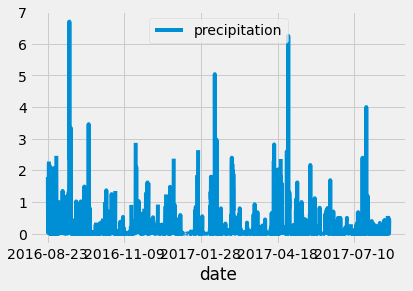

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
prev_year = dt.date(2017, 8,23)
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8,23) - dt.timedelta(days =365)
# Perform a query to retrieve the data and precipitation scores
results = []
# Save the query results as a Pandas DataFrame and set the index to the date column
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Sort the dataframe by date
df = pd.DataFrame(results, columns = ['date','precipitation'])
#  ,inplace = True) allows us to use the same df to make the change. Does not copy over it.  Set_index allows us to move to reference the index column as the iniiial column
df.set_index(df['date'], inplace =True)

#code below allows us to convert the df to a string and the index=False allows us to print the data without the index being displayed
df = df.sort_index()


#print(df.to_string(index=False))
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
#-session.query- how we start a query, func.count will list the station and count by stations, -group_by- will group stations name together, order by will list station in order
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
## Info in left column is station ID number and the number on the righ is the number of readings the station made.

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# I believe tobs means temp observations
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station =='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

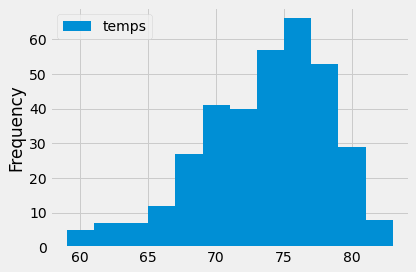

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['temps'])
df.plot.hist(bins =12)
plt.tight_layout()


In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


# Challenge

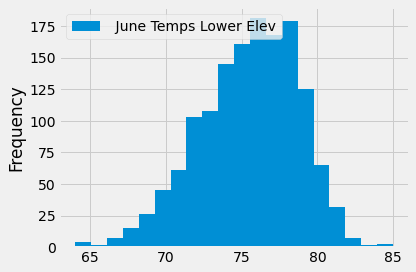

In [18]:
#location_temps=session.query(Measurement.tobs, Measurement.station).filter(Measurement.station  == Station.station)
june_location_temps=session.query(Measurement.station, Measurement.tobs).filter(Measurement.station  == Station.station).\
    filter(extract('month', Measurement.date) ==6).\
    filter(Station.elevation <= 40).all()
june_location_temps = pd.DataFrame(june_location_temps, columns =['Station',' June Temps Lower Elev'])
june_location_temps.set_index('Station', inplace=True)
june_location_temps.plot.hist(bins = 20)
plt.tight_layout()
plt.show()


In [19]:
june_location_temps.describe()

,June Temps Lower Elev
count,1439.000000
mean,75.451008
std,3.118911
min,64.000000
25%,73.000000
50%,76.000000
75%,78.000000
max,85.000000


(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(-50.0, 0, '2016-06-11'),
  Text(0.0, 0, '2010-06-01'),
  Text(50.0, 0, '2011-06-21'),
  Text(100.0, 0, '2013-06-11'),
  Text(150.0, 0, '2015-06-01'),
  Text(200.0, 0, '2016-06-21'),
  Text(250.0, 0, ''),
  Text(300.0, 0, '')])

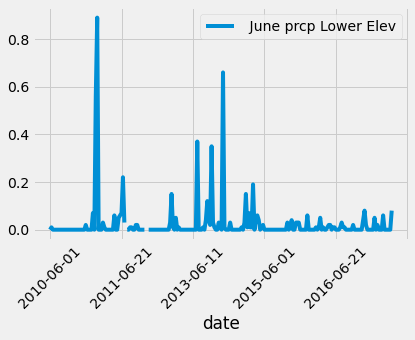

In [30]:
june_location_prcp=session.query(Measurement.date, Measurement.prcp).filter(Measurement.station  == Station.station).\
    filter(extract('month', Measurement.date) ==6).\
    filter(Station.elevation <= 40).group_by(Measurement.date).all()
june_location_prcp = pd.DataFrame(june_location_prcp, columns =['date',' June prcp Lower Elev'])
june_location_prcp.set_index('date', inplace=True)
june_location_prcp.plot()
plt.xticks(rotation = 45)

In [21]:
june_location_prcp.describe()

,June prcp Lower Elev
count,1334.000000
mean,0.079520
std,0.243743
min,0.000000
25%,0.000000
50%,0.010000
75%,0.070000
max,4.430000


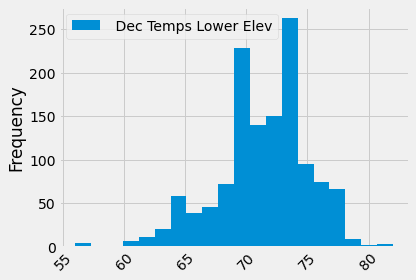

In [26]:
location_temps=session.query(Measurement.station, Measurement.tobs).filter(Measurement.station  == Station.station).\
    filter(extract('month', Measurement.date) ==12).\
    filter(Station.elevation <= 40).all()
dec_location_temps = pd.DataFrame(location_temps, columns =['Station',' Dec Temps Lower Elev'])
dec_location_temps.set_index('Station', inplace=False)
dec_location_temps.plot.hist(bins = 20)
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

In [23]:
dec_location_temps.describe()

,Dec Temps Lower Elev
count,1292.000000
mean,71.300310
std,3.775813
min,56.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,82.000000


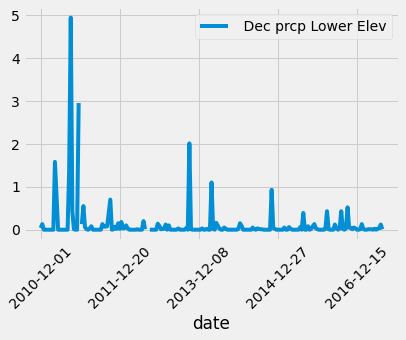

In [31]:
dec_location_prcp=session.query(Measurement.date, Measurement.prcp).filter(Measurement.station  == Station.station).\
    filter(extract('month', Measurement.date) ==12).\
    filter(Station.elevation <= 40).group_by(Measurement.date).all()
dec_location_prcp = pd.DataFrame(dec_location_prcp, columns =['date',' Dec prcp Lower Elev'])
dec_location_prcp.set_index('date', inplace=True)
dec_location_prcp.plot()#(x ='date',y = ['prcp'],kind="bar",figsize =(9,8))
plt.xticks(rotation = 45)
plt.show()

In [25]:
dec_location_prcp.describe()

,Dec prcp Lower Elev
count,1197.000000
mean,0.165188
std,0.456738
min,0.000000
25%,0.000000
50%,0.020000
75%,0.110000
max,4.950000
